# LDA Projection

### This document contains 4 parts
1. Some notes the theory of LDA projection
2. The LDA function used for the project
3. A step by step explanation of what the function does
4. A lot of plots - some used for our GIF

### There will be printed a lot of plots, so we advice you not to run the whole kernel at once.

#### This code is based on the code from [Towards Data Science](https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2) 

# Theory Notes
**Goal:** 

Find a low-dimensional space, such that classes are wellseparated by:

- **Maximize** distance between the means of projected classes
- **Minimize** variance for each projected class

#### LDA with K>2 Classes
We want the matrix $\textbf W$ such that $\matrix{Z}=\matrix{W}{^T}\mathbf x$

Where Z is K dimensional and W is $D\times K$ dimensional

**Remember:** $\mathbf W$ is the axis('s)we project the data onto to get the best seperation. 

Find $\matrix W$ that maximizes 

**Within-class scatter:** 

The within-class scatter matrix for class $C_i$ is 
$$ \mathbf{S}_{i}=\sum_{t} r_{i}^{t}\left(\mathbf{x}^{t}-\mathbf{m}_{i}\right)\left(\mathbf{x}^{t}-\mathbf{m}_{i}\right)^{T} $$
Where $r^{t}_i = 1$ if $\mathbf {x}^t \in C_i$ and 0 otherwise

The total within-class scatter matrix is therefore:
$$ \mathbf{S}_{w}=\sum_{i=1}^{\kappa} \mathbf{S}_{i}$$

When there are $K > 2$ classes, the scatter of the means is calculated as how much they are scattered around the **overall mean** $\mathbf m$

$$ \mathbf{m}=\frac{1}{K} \sum_{i=1}^{k} \mathbf{m}_{i} $$


**Between-class scatter:**

$$
\mathbf{S}_{B}=\sum_{i=1}^{K} N_{i}\left(\mathbf{m}_{i}-\mathbf{m}\right)\left(\mathbf{m}_{i}-\mathbf{m}\right)^{T}
$$
Here $\textbf{S}_B$ is the 'between-class scatter matrix'
    
### Goal:

Find $\textbf W$ that max
$$
J(\mathbf{W})=\frac{\left|\mathbf{W}^{T} \mathbf{S}_{B} \mathbf{W}\right|}{\left|\mathbf{W}^{T} \mathbf{S}_{W} \mathbf{W}\right|}
$$

Remember that W is the vector we project $\mathbf x$ onto. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
import pickle
import re

In [4]:
df = pd.read_csv("df_train.csv")

df = df.replace({"type":1},0)
df = df.replace({"type":2},1)
df = df.replace({"type":3},2)
df = df.replace({"type":5},3)
df = df.replace({"type":6},4)
df = df.replace({"type":7},5)

In [5]:
df.rename(columns={"type":'class'},inplace=True)

In [6]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.51839,12.85,3.67,1.24,72.57,0.62,8.68,0.00,0.35,1
1,1.52081,13.78,2.28,1.43,71.99,0.49,9.85,0.00,0.17,1
2,1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.00,0.00,1
3,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.00,0.00,1
4,1.52210,13.73,3.84,0.72,71.76,0.17,9.74,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
144,1.51755,12.71,3.42,1.20,73.20,0.59,8.64,0.00,0.00,0
145,1.51800,13.71,3.93,1.54,71.81,0.54,8.21,0.00,0.15,1
146,1.52365,15.79,1.83,1.31,70.43,0.31,8.61,1.68,0.00,5
147,1.51571,12.72,3.46,1.56,73.20,0.67,8.09,0.00,0.24,0


# LDA Function

In [12]:
def LDA(df,plot=False):
    class_feature_means = pd.DataFrame(columns= df['class'].unique())
    
    for c, rows in df.groupby('class'):
        class_feature_means[c] = rows.mean()
    
    class_feature_means = class_feature_means.drop(['class'])
    
    within_class_scatter_matrix = np.zeros((9,9))

    for c, rows in df.groupby('class'):
        rows = rows.drop(['class'], axis=1) # removes the class from the dataframe
        s = np.zeros((9,9))
        for index, row in rows.iterrows():
            x, mc = row.values.reshape(9,1), class_feature_means[c].values.reshape(9,1)
            s += (x - mc).dot((x - mc).T)
        within_class_scatter_matrix += s

        
    feature_means = df.drop('class',axis=1).mean()
    between_class_scatter_matrix = np.zeros((9,9))
    
    for c in class_feature_means:    
        n = len(df.loc[df['class'] == c].index) # the number of values of class c

        mc, m = class_feature_means[c].values.reshape(9,1), feature_means.values.reshape(9,1)
        #mc, m = class_feature_means[c].values, feature_means.values

        between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)
        
    
    eigen_values, eigen_vectors = \
    np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))
    
    pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
    
    pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
    
    w_matrix = np.hstack((pairs[0][1].reshape(9,1), pairs[1][1].reshape(9,1))).real
    
    X_lda = np.array(df.drop('class',axis=1).dot(w_matrix))
    
    if plot:
        classes = ['Windows from building FP','Windows from building N-FP','Window from vehicle','Container','Tableware','Headlamp']
        fig = plt.figure(figsize=(16,16))
        plt.xlabel('LDA0'); plt.ylabel('LDA1')

        scatter = plt.scatter(X_lda[:,0], X_lda[:,1], c=df['class'], cmap='rainbow', alpha=0.7, edgecolors='b')
        handles, labels = scatter.legend_elements()
        map_labels = [classes[int(re.search('\d', label).group())] for label in labels]
        plt.legend(handles, map_labels,loc="best",title="Classes")
        plt.show()


    return(X_lda)

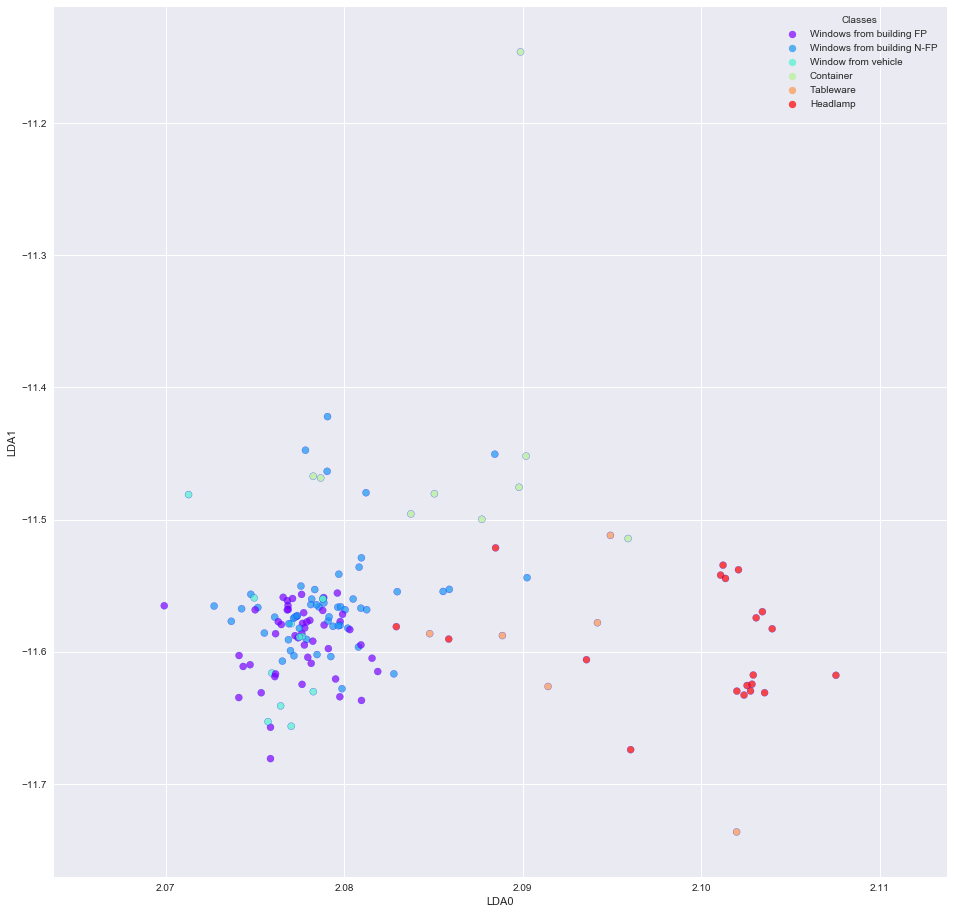

array([[  2.07425668, -11.56750522],
       [  2.082975  , -11.55456803],
       [  2.08093708, -11.5670626 ],
       [  2.07783428, -11.44753083],
       [  2.07535629, -11.63106356],
       [  2.08020539, -11.58217379],
       [  2.07477432, -11.55656934],
       [  2.08373969, -11.49572101],
       [  2.07818357, -11.56018443],
       [  2.10257144, -11.62557399],
       [  2.07658529, -11.55883223],
       [  2.07925556, -11.60367859],
       [  2.1075503 , -11.61785115],
       [  2.07587551, -11.68091071],
       [  2.07762884, -11.58618324],
       [  2.079622  , -11.55560677],
       [  2.0935761 , -11.60605912],
       [  2.07970333, -11.54133344],
       [  2.07758114, -11.55032922],
       [  2.07952187, -11.62064704],
       [  2.08084031, -11.53601413],
       [  2.10308076, -11.57437889],
       [  2.10108985, -11.54203254],
       [  2.08479389, -11.58634431],
       [  2.07703819, -11.57876335],
       [  2.07654145, -11.60711939],
       [  2.09142439, -11.6263129 ],
 

In [13]:
LDA(df,plot=True)